<a href="https://colab.research.google.com/github/sujoynitk/potato-disease-prediction/blob/main/Potato_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [48]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data/PotatoPlants",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 1685 files belonging to 3 classes.


In [5]:
CLASS_NAMES = dataset.class_names

In [13]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 1 2 2 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0]


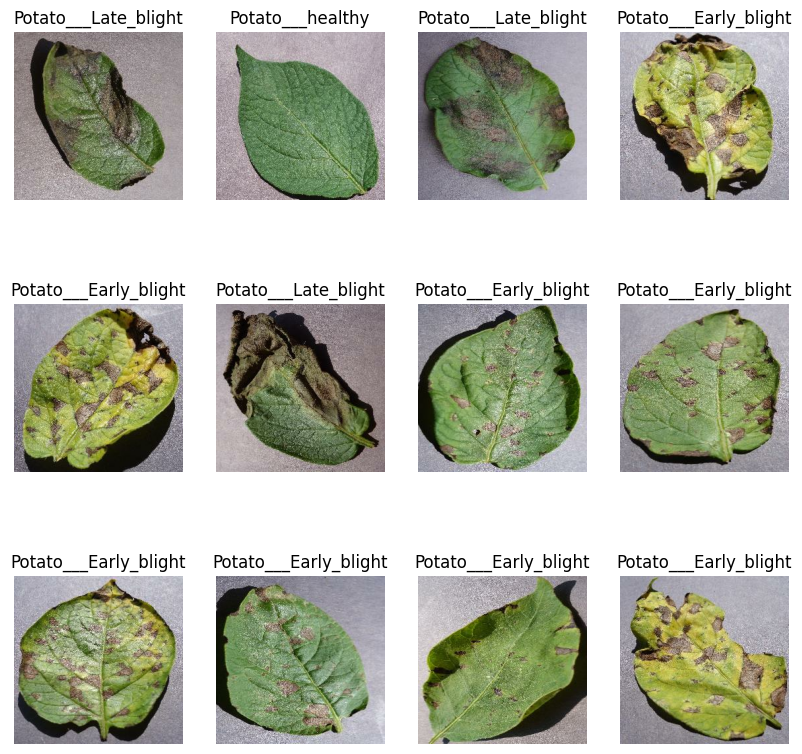

In [22]:
for image_batch, label_batch in dataset.take(1):
  plt.figure(figsize=(10,10))
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(CLASS_NAMES[label_batch.numpy()[i]])

Train-Validation-Test dataset split = 80-10-10

In [37]:
dataset_size = len(dataset)
dataset_size

53

In [38]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

In [39]:
ds_train = dataset.take(int(round(dataset_size * train_size, 0)))
ds_val = dataset.skip(len(ds_train)).take(int(round(dataset_size * val_size, 0)))
ds_test = dataset.skip(len(ds_train) + len(ds_val)).take(int(round(dataset_size * test_size, 0)))

In [40]:
print(f"{len(ds_train)} {len(ds_val)} {len(ds_test)}")

42 5 5


In [41]:
def split_datasets(ds, train_size, val_size, test_size, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=42)
  ds_train = ds.take(int(round(ds_size * train_size, 0)))
  ds_val = ds.skip(len(ds_train)).take(int(ds_size * val_size))
  ds_test = ds.skip(len(ds_train) + len(ds_val)).take(int(ds_size * test_size))
  return ds_train, ds_val, ds_test

In [42]:
ds_train, ds_val, ds_test = split_datasets(dataset, train_size, val_size, test_size)

In [43]:
print(f"{len(ds_train)} {len(ds_val)} {len(ds_test)}")

42 5 5


In [44]:
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [47]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [53]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
kernel_size = (3, 3)
pooling_size = (2, 2)
n_classes = len(CLASS_NAMES)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
    layers.MaxPooling2D(pooling_size),
    layers.Conv2D(filters=64, kernel_size=kernel_size, activation="relu"),
    layers.MaxPooling2D(pooling_size),
    layers.Conv2D(filters=64, kernel_size=kernel_size, activation="relu"),
    layers.MaxPooling2D(pooling_size),
    layers.Conv2D(filters=64, kernel_size=kernel_size, activation="relu"),
    layers.MaxPooling2D(pooling_size),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [54]:
model.build(input_shape=input_shape)

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [58]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [59]:
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=ds_val
)

Epoch 1/50
42/42 [==============================] - 15s 138ms/step - loss: 0.6528 - accuracy: 0.7074 - val_loss: 0.4802 - val_accuracy: 0.8000
Epoch 2/50
42/42 [==============================] - 2s 59ms/step - loss: 0.3340 - accuracy: 0.8642 - val_loss: 0.2994 - val_accuracy: 0.8687
Epoch 3/50
42/42 [==============================] - 2s 58ms/step - loss: 0.2510 - accuracy: 0.8995 - val_loss: 0.4046 - val_accuracy: 0.8250
Epoch 4/50
42/42 [==============================] - 2s 60ms/step - loss: 0.3001 - accuracy: 0.8710 - val_loss: 0.2410 - val_accuracy: 0.9125
Epoch 5/50
42/42 [==============================] - 2s 58ms/step - loss: 0.1968 - accuracy: 0.9287 - val_loss: 0.1418 - val_accuracy: 0.9563
Epoch 6/50
42/42 [==============================] - 2s 57ms/step - loss: 0.1669 - accuracy: 0.9325 - val_loss: 0.3538 - val_accuracy: 0.8625
Epoch 7/50
42/42 [==============================] - 2s 57ms/step - loss: 0.1791 - accuracy: 0.9295 - val_loss: 0.1975 - val_accuracy: 0.9375
Epoch 8/50


In [60]:
scores = model.evaluate(ds_test)

5/5 [==============================] - 2s 28ms/step - loss: 0.0152 - accuracy: 0.9937


In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training vs Validation Loss')

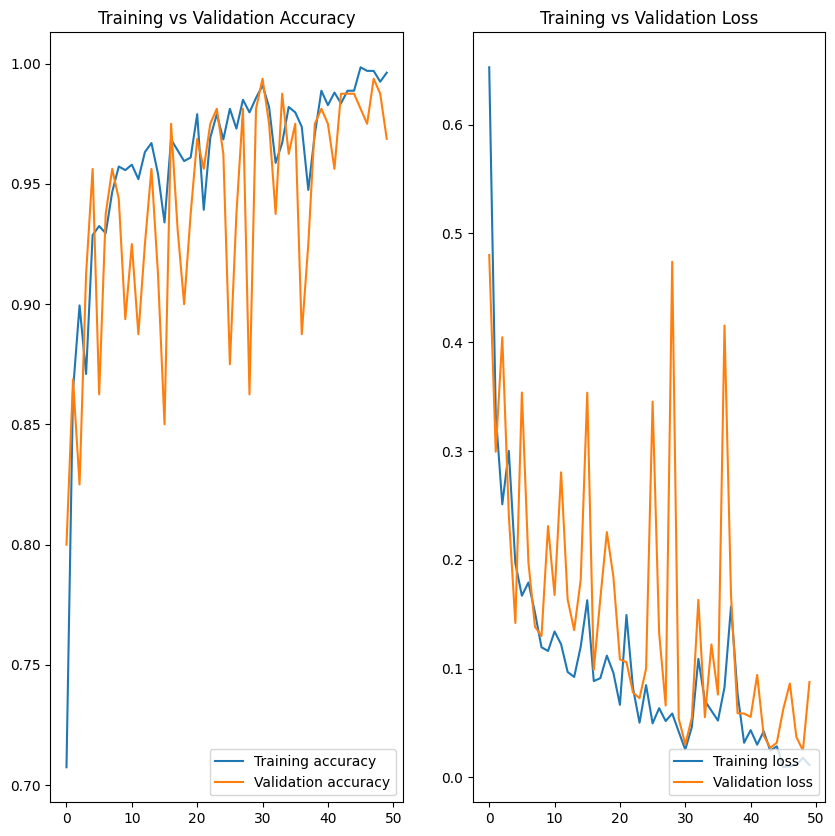

In [65]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training vs Validation Accuracy")
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training vs Validation Loss")

In [68]:
import numpy as np

1/1 [==============================] - 0s 30ms/step


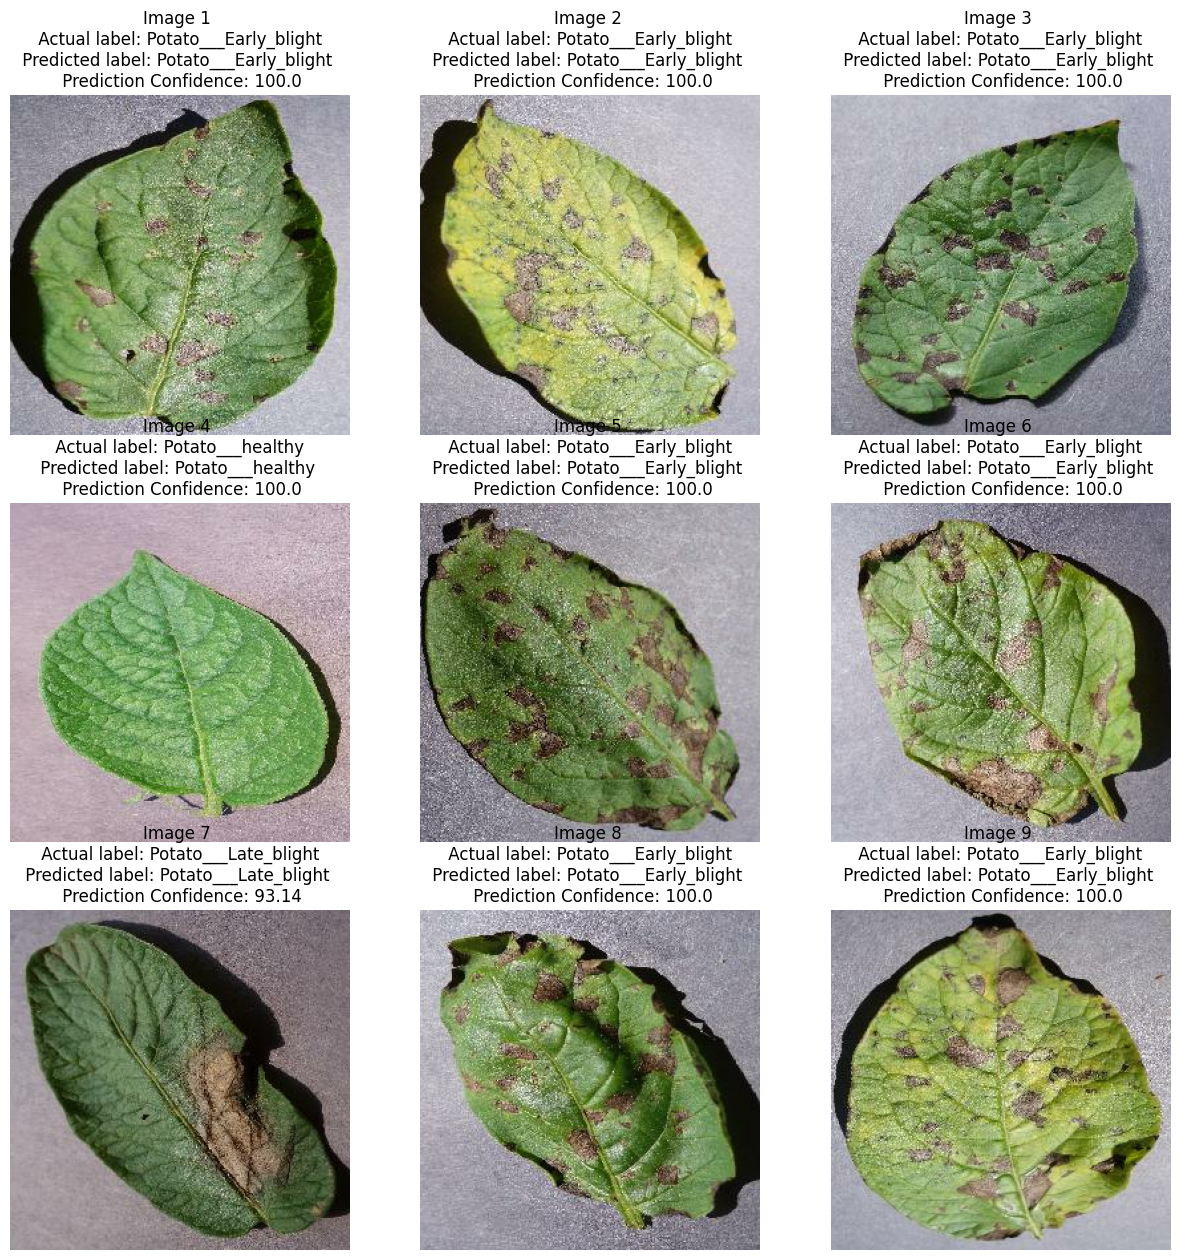

In [77]:
for images_batch, label_batch in ds_test.take(1):
  predictions = model.predict(images_batch)
  plt.figure(figsize=(15,15))
  for i in range(9):
    plt.subplot(3,3,i+1)
    image = images_batch[i].numpy().astype("uint8")
    actual_label = CLASS_NAMES[label_batch[i]]
    prediction = CLASS_NAMES[np.argmax(predictions[i])]
    confidence = round(np.max(predictions[i]) * 100, 2)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {i+1} \n Actual label: {actual_label} \n Predicted label: {prediction}  \n Prediction Confidence: {confidence}")

In [79]:
model.save("/content/models/pdpmodel.keras")